In [2]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters

import numpy as np
import datetime
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
register_matplotlib_converters()

from scipy.optimize import curve_fit
from datetime import timedelta
from datetime import datetime
from io import StringIO
from urllib import request as url_request

In [3]:
days_past = -2 # days beyond the start of the data to plot
days_future = 20 # days after the end of the data to predict and plot

myFmt = mdates.DateFormatter('%d/%m') # date formatter for matplotlib
show_every = 2 # int value that defines how often to show a date in the x axis.

coeff_std = 1.1 # coefficient that defines how many standard deviations to use
coeff_std_d = 0.4

In [4]:
def logistic(x, L, k, x0, y0):
    """
    General Logistic function.

    Args:
        x    float or array-like, it represents the time
        L    float, the curve's maximum value
        k    float, the logistic growth rate or steepness of the curve.
        x0   float, the x-value of the sigmoid's midpoint
        y0   float, curve's shift in the y axis
    """
    y = L / (1 + np.exp(-k*(x-x0))) + y0
    return y

In [5]:
def logistic_derivative(x, L, k, x0):
    """
    General Gaussian like function (derivative of the logistic).

    Args:
        x    float or array-like, it represents the time
        L    float, the curve's integral (area under the curve)
        k    float, the logistic growth rate or steepness of the curve.
        x0   float, the x-value of the max value
    """
    y = k * L * (np.exp(-k*(x-x0))) / np.power(1 + np.exp(-k*(x-x0)), 2)
    return y

In [6]:
def fit_curve(curve, ydata, title, ylabel, last_date, coeff_std):
    xdata = np.array(list(range(-len(ydata), 0))) + 1

    if curve.__name__ == 'logistic':
        p0=[20000, 0.5, 1, 0]
        bounds=([0, 0, -100, 0], [200000, 10, 100, 1])
        params_names = ['L', 'k', 'x0', 'y0']
    elif curve.__name__ == 'logistic_derivative':
        p0=[20000, 0.5, 1]
        bounds=([0, 0, -100], [200000, 10, 100])
        params_names = ['L', 'k', 'x0']
    else:
        print('this curve is unknown')
        return -1

    popt, pcov = curve_fit(curve, xdata, ydata, p0=p0, bounds=bounds)

    print(title)
    descr = '    fit: '
    
    for i, param in enumerate(params_names):
        descr = descr + "{}={:.3f}".format(param, popt[i])
        if i < len(params_names) - 1:
            descr = descr + ', '
    print(descr)

    perr = np.sqrt(np.diag(pcov))
    print(perr)

    pworst = popt + coeff_std*perr
    pbest = popt - coeff_std*perr

    fig, ax = plt.subplots(figsize=(15,8))

    ax.xaxis.set_major_formatter(myFmt)
    fig.autofmt_xdate()

    total_xaxis = np.array(list(range(-len(ydata) + days_past, days_future))) + 1

    date_xdata = [last_date + timedelta(days=int(i)) for i in xdata]
    date_total_xaxis = [last_date + timedelta(days=int(i)) for i in total_xaxis]

    ax.plot(date_total_xaxis, curve(total_xaxis, *popt), 'g-', label='prediction')
    ax.plot(date_xdata, ydata, 'b-', label='real data')

    future_axis = total_xaxis[len(ydata) - days_past:]
    date_future_axis = [last_date + timedelta(days=int(i)) for i in future_axis]
    ax.fill_between(date_future_axis, curve(future_axis, *pbest), curve(future_axis, *pworst), 
        facecolor='red', alpha=0.2, label='std')

    start = (len(ydata) - days_past - 1) % show_every
    ax.set_xticks(date_total_xaxis[start::show_every])
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)
    ax.set_title(title + ' - ' + str(last_date.strftime("%d-%m-%Y")))
    ax.legend(loc='upper left')
    ax.grid(True)

    return popt, perr

# Read data

In [7]:
data = pd.read_csv('../data/final_data/dataCOVID19_es.csv')
Spain = data.groupby('fecha', as_index=False).sum()
Spain

,fecha,casos,IA,UCI,muertes,Hospitalizados,nuevos
0,2020-03-02,114.0,0.00,0.0,0.0,0.0,0.0
1,2020-03-03,150.0,6.63,0.0,0.0,0.0,36.0
2,2020-03-04,198.0,9.55,7.0,0.0,0.0,48.0
3,2020-03-05,237.0,11.76,9.0,3.0,0.0,39.0
4,2020-03-06,365.0,20.55,11.0,5.0,0.0,128.0
5,2020-03-07,577.0,30.80,29.0,8.0,0.0,0.0
6,2020-03-08,787.0,41.04,50.0,13.0,0.0,0.0
7,2020-03-09,999.0,51.29,68.0,16.0,0.0,634.0
8,2020-03-10,1622.0,87.11,100.0,35.0,0.0,623.0
9,2020-03-11,2128.0,114.39,142.0,47.0,0.0,506.0


In [8]:
Confirmed=Spain.casos.values
Deaths=Spain.muertes.values
dates=pd.to_datetime(Spain.fecha.values)
last_date = datetime.strptime(Spain.fecha.values[-1], "%Y-%m-%d")

In [9]:
nuevos_casos = [np.nan]+list(Spain.casos.values[1:] - Spain.casos.values[:-1])
nuevos_casos


[nan,
 36.0,
 48.0,
 39.0,
 128.0,
 212.0,
 210.0,
 212.0,
 623.0,
 506.0,
 822.0,
 1259.0,
 1544.0,
 2000.0,
 1438.0,
 1987.0,
 2538.0,
 3431.0,
 2833.0,
 4946.0]

Number of confirmed cases 24926


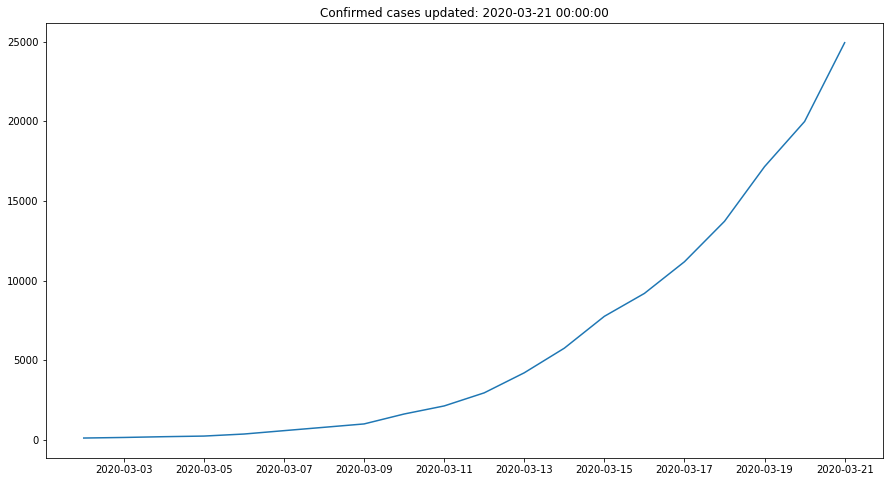

In [10]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(dates,Confirmed)
ax.set_title("Confirmed cases updated: {}".format(dates[-1]));
print('Number of confirmed cases {:.0f}'.format(Confirmed[-1]))

Confirmed
    fit: L=52605.391, k=0.289, x0=0.500, y0=0.000
[9.61338512e+03 2.32854908e-02 1.12678618e+00 2.16483764e+02]


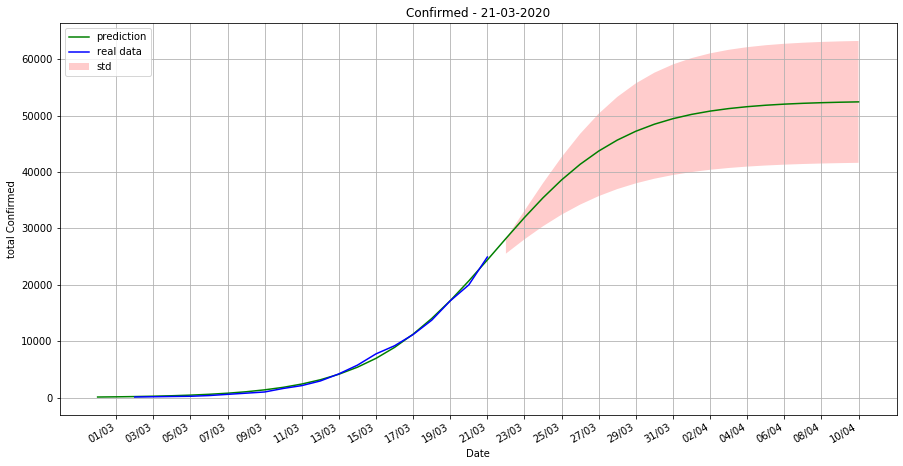

In [11]:
p_cont, err_cont = fit_curve(logistic, Confirmed, 'Confirmed', 'total Confirmed', last_date, coeff_std)

Number of deaths 1326


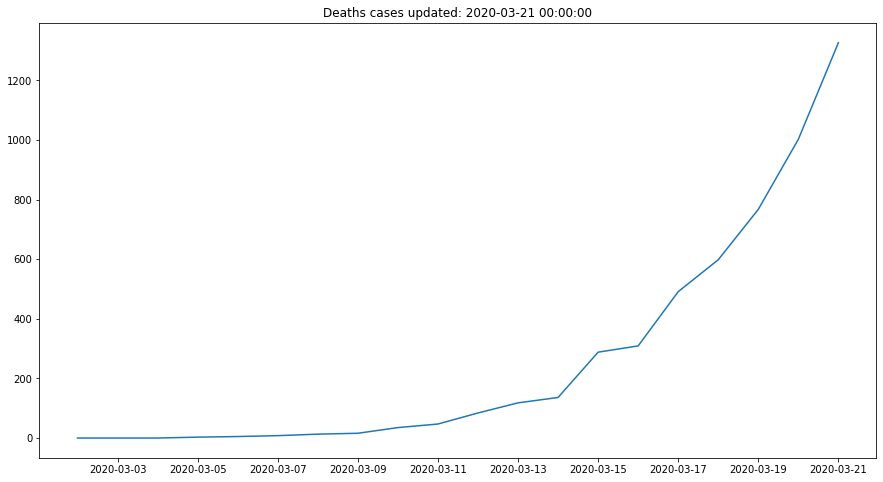

In [12]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(dates,Deaths)
ax.set_title("Deaths cases updated: {}".format(dates[-1]));
print('Number of deaths {:.0f}'.format(Deaths[-1]))

Deaths
    fit: L=4005.490, k=0.341, x0=2.123, y0=0.000
[1.48156939e+03 3.28480621e-02 1.74897126e+00 1.05220207e+01]


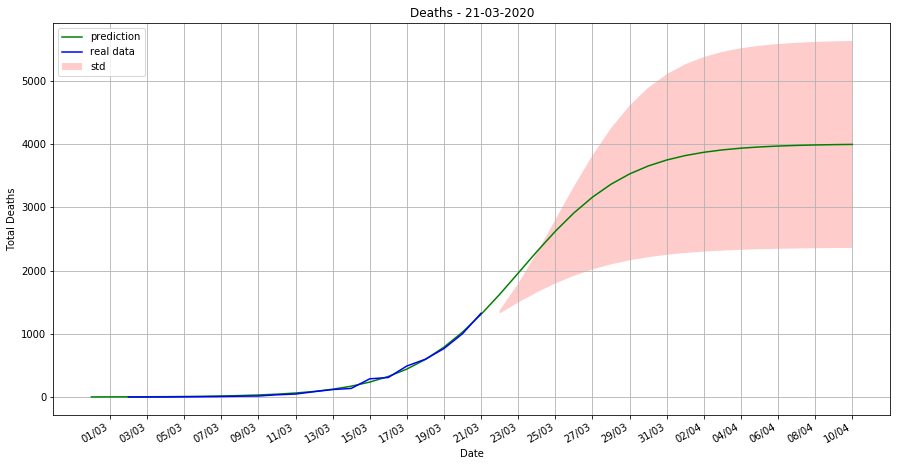

In [13]:
p_dead, err_dead = fit_curve(logistic, Deaths, 'Deaths', 'Total Deaths', last_date, coeff_std)

In [14]:
Confirmed

array([  114.,   150.,   198.,   237.,   365.,   577.,   787.,   999.,
        1622.,  2128.,  2950.,  4209.,  5753.,  7753.,  9191., 11178.,
       13716., 17147., 19980., 24926.])

In [24]:
tempVar=np.diff(Confirmed)
tempVar[tempVar==0]=np.nan
newConfirmed=tempVar
datesNewConfirmed=dates[1:]

In [25]:
growth_factor = newConfirmed[1:] / newConfirmed[:-1]
dates_growth_factor = datesNewConfirmed[1:]

print('Last growth factor: {:.3f}'.format(growth_factor[-1]))
print('Mean growth  factor: {:.3f}'.format(np.mean(growth_factor[-5:])))

Last growth factor: 1.746
Mean growth  factor: 1.316


New cases
    fit: L=200000.000, k=0.213, x0=9.472
[3.80948398e+05 5.35176405e-02 1.22116890e+01]


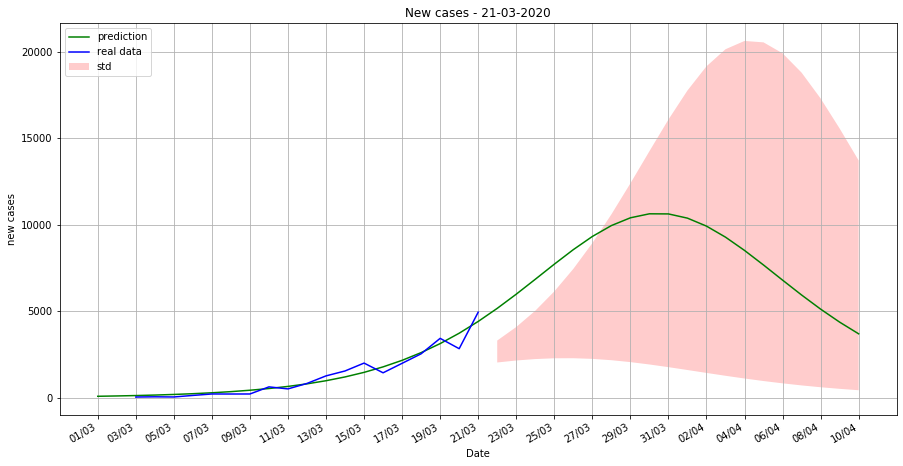

In [28]:
newConfirmed=np.diff(Confirmed)

fit_curve(logistic_derivative, newConfirmed, 'New cases', 'new cases', last_date, coeff_std_d);

array([  7.,   7.,   7.,   8.,  11.,  15.,  18.,  22.,  25.,  37.,  51.,
        70.,  90., 109., 119., 148., 181., 220., 287., 348.])

New cases
    fit: L=199999.996, k=0.211, x0=30.598
[3.99473111e+07 6.88624820e-02 9.57779406e+02]


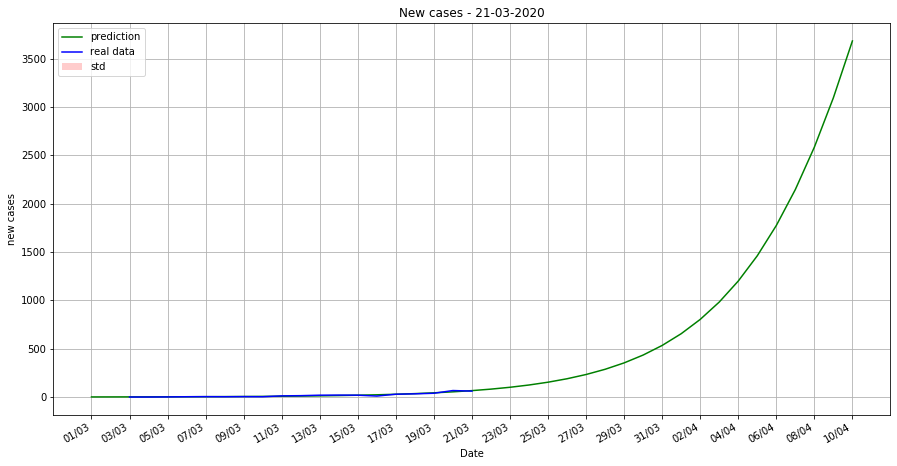

In [29]:
ConfirmedCCAA=data[data.CCAA=='Canarias'].casos.values
fit_curve(logistic_derivative, np.diff(ConfirmedCCAA), 'New cases', 'new cases', last_date, coeff_std_d);